In [1]:
# !pip install --quiet --pre --upgrade dgl-cu101
# !pip install --quiet torch==1.6.0

In [2]:
import argparse
import itertools
import os
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
import pandas as pd
import scipy.sparse as sp
import time
from tqdm import tqdm, tqdm_notebook,tnrange
tqdm.pandas(position=0, leave=True)
import math 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import dgl.function as Fn
from functools import partial
import seaborn as sns
import pickle
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
import tsne_func
print("torch version is {}".format(th.__version__))
print("DGL version is {}".format(dgl.__version__))

Using backend: pytorch


torch version is 1.6.0
DGL version is 0.6a210111


In [3]:
def seed_everything(seed):
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [4]:
KG_dir="/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/"
start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph'), 'rb') as f:
    G, node_labels = pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))

It took 8.6785 seconds to load graph


In [5]:
utils.graph_show(G)

**************************************************
Node_types:  ['usaanr']
Edge_types:  ['AUTO_RELATED', 'Brother_Sister', 'Busi_rel_Other', 'Child', 'Ex-Spouse', 'Parent', 'Pers_rel_Other', 'SPONSEE', 'SPONSOR', 'Spouse', 'Step-Child', 'Step-Parent']
**************************************************
Canonical Etypes of Graph is:

usaanr              AUTO_RELATED        usaanr              
usaanr              Brother_Sister      usaanr              
usaanr              Busi_rel_Other      usaanr              
usaanr              Child               usaanr              
usaanr              Ex-Spouse           usaanr              
usaanr              Parent              usaanr              
usaanr              Pers_rel_Other      usaanr              
usaanr              SPONSEE             usaanr              
usaanr              SPONSOR             usaanr              
usaanr              Spouse              usaanr              
usaanr              Step-Child          usaanr          

In [6]:
usaanr_feat=[]
for key, scheme in G.node_attr_schemes(ntype="usaanr").items():
    usaanr_feat.append(key)
usaanr_feat=[x for x in usaanr_feat if x not in ['ZIPCD','train_mask','val_mask','test_mask']]

print()
print("The features associated with USAA Member are\n ")
for i in usaanr_feat:
    print(i)


The features associated with USAA Member are
 
usaayr
AGE_BAND
ORIGEL
ELIG2
cmpyelig
SEX
MARST
BRANCH
ENLPAYGD
MILST
MLIST_OrigStat
ACTCORP
STATE
Segment


In [7]:
## USAA Members Features Embedding
class USAANR_Embedding(nn.Module):
    def __init__(self,G,feature_size):
        super(USAANR_Embedding,self).__init__()
        self.G=G.to(device)
        self.feature_size=feature_size
        ## Embedding matrices for features of nodes.
        self.emb = nn.ModuleDict()
        
        for i,col in enumerate(usaanr_feat):
            self.emb[col]=nn.Embedding(G.nodes['usaanr'].data[col].max().item()+1, feature_size)
    
    def forward(self,nid):
        nid=nid.to(device)
        extra_repr=[]
        
        for i,col in enumerate(usaanr_feat):
            ndata=self.G.nodes['usaanr'].data[col]
            extra_repr.append(self.emb[col](ndata[nid]).squeeze(1))
        return th.stack(extra_repr, 0).sum(0)


In [8]:
class RelGraphConvLayer(nn.Module):
    r"""Relational graph convolution layer.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 num_bases,
                 *,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.conv = dglnn.HeteroGraphConv({
#                 rel : dglnn.GraphConv(in_feat, out_feat, norm="both", weight=False, bias=False)
                rel : dglnn.SAGEConv(in_feat, out_feat, aggregator_type='mean',feat_drop=0.,bias=True,norm=None)
                for rel in rel_names
            })
        self.use_weight = weight
        self.use_basis = num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = dglnn.WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))
        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)
        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))
        self.dropout = nn.Dropout(dropout)
    def forward(self, g, inputs):
        """Forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.
        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}
        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs
        hs = self.conv(g, inputs)
        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}

In [9]:
class Entity_Classify(nn.Module):
    def __init__(self,
                 g,
                 h_dim,
                 out_dim,
                 num_bases,
#                  embed_layer,
                 num_hidden_layers=1,
                 dropout=0,
                 use_self_loop=False):
        super(Entity_Classify, self).__init__()
        self.g = g
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.rel_names = list(set(g.etypes))
#         self.num_bases = None if num_bases < 0 else num_bases
        if num_bases < 0 or num_bases > len(self.rel_names):
            self.num_bases = len(self.rel_names)
        else:
            self.num_bases = num_bases
            
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.use_self_loop = use_self_loop
        
#         self.node_embed={}
        self.node_embed=nn.ModuleDict()
        self.node_embed['usaanr'] = USAANR_Embedding(self.g,self.h_dim)
#         self.node_embed['zipcode'] = Zipcode_Embedding(self.g,self.h_dim)
        self.layers = nn.ModuleList()
        #i2h
        self.layers.append(RelGraphConvLayer(
                    self.h_dim, self.h_dim, self.rel_names,
                    self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                    dropout=self.dropout, weight=True))
        # h2h
        if self.num_hidden_layers>1:
            for i in range(0,self.num_hidden_layers-1):
                self.layers.append(RelGraphConvLayer(
                    self.h_dim, self.h_dim, self.rel_names,
                    self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                    dropout=self.dropout))
        # h2o
#         self.layers.append(RelGraphConvLayer(
#             self.h_dim, self.out_dim, self.rel_names, 
#             self.num_bases, activation=partial(F.softmax, dim=1),
#             self_loop=self.use_self_loop))
        self.classifier = nn.Linear(self.h_dim, self.out_dim)
    
    def forward(self, input_nodes, blocks=None):
        H={}
        for ntype, nid in input_nodes.items():
            nid = input_nodes[ntype]
            H[ntype] = self.node_embed[ntype](nid)
        if blocks is None:
            for layer in self.layers:
                H = layer(self.g, H)
        else:
            for layer, block in zip(self.layers, blocks):
                H = layer(block, H)
        output = self.classifier(H["usaanr"])
    
        return output, H["usaanr"]

In [10]:
def evaluate(model, loader, labels, category, device):
    model.eval()
    total_loss = 0
    total_acc = 0
#     total_precision=0
#     total_recall=0
    total_fscore_macro=0
    total_fscore_micro=0
    total_fscore_weighted=0
#     total_auc=0
#     total_pr_auc=0
    
    count = 0
    count_loss=0
    
    y_pred=[]
    y_true=[]
    
    for input_nodes_raw, seeds_raw, blocks in tqdm(loader, position=0, leave=True):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)
        
        input_nodes={}
        input_nodes[category]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
        lbl = labels[seeds].to(device)
        logits,h = model(input_nodes,blocks)
        loss = F.cross_entropy(logits, lbl.squeeze(1).to(device))
#         loss = F.cross_entropy(logits, lbl.squeeze(1),weight=th.Tensor([1,args.weight]).to(device))
        acc = th.sum(logits.argmax(dim=1) == lbl.squeeze(1)).item() / logits.shape[0]
#         precision, recall, fscore, support = score(lbl.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy())

        precision_macro, recall_macro, fscore_macro, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='macro')
        precision_micro, recall_micro, fscore_micro, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='micro')
        precision_weighted, recall_weighted, fscore_weighted, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='weighted')
        
        y_pred.extend(logits.argmax(dim=1).tolist())
        y_true.extend(lbl.squeeze().tolist())
        
#         tempt=lbl.detach().cpu().numpy()
#         labels_train_one_hot=np.zeros(shape=(tempt.shape[0],8),dtype=np.float32)
#         labels_train_one_hot[np.arange(tempt.shape[0]),np.array([ele.item() for ele in tempt])]=1
#         auc = roc_auc_score(labels_train_one_hot.ravel(), th.sigmoid(logits).detach().cpu().numpy().ravel())
        
#         auc = roc_auc_score(lbl.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
#         prec,rec,_ = precision_recall_curve(lbl.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
#         pr_auc=auc_score(rec,prec)
        
        total_loss += loss.item() * len(seeds) 
        total_acc += acc
#         total_precision += precision[1]
#         total_recall += recall[1]
        total_fscore_macro += fscore_macro
        total_fscore_micro += fscore_micro
        total_fscore_weighted += fscore_weighted
#         total_auc += auc
#         total_pr_auc += pr_auc
        count += 1
        count_loss += len(seeds)
    
    ACCURACY=total_acc / count
    LOSS=total_loss / count_loss
#     PRECISION=total_precision/count
#     RECALL=total_recall/count
    F1_SCORE_macro=total_fscore_macro/count
    F1_SCORE_micro=total_fscore_micro/count
    F1_SCORE_weighted=total_fscore_weighted/count
#     AUC=total_auc/count
#     PR_AUC=total_pr_auc/count
    
    return ACCURACY, LOSS, F1_SCORE_macro, F1_SCORE_micro, F1_SCORE_weighted, y_pred, y_true

In [11]:
def inference(model, graph, input_features, batch_size):
    """Minibatch inference of final representation over all node types.
    ***NOTE***
    For node classification, the model is trained to predict on only one node type's
    label.  Therefore, only that type's final representation is meaningful.
    """
    with th.no_grad():
        for l, layer in enumerate(model.layers):
            
            output_features = {
                k: th.zeros(
                    graph.number_of_nodes(k),
                    args.h_dim )
                for k in graph.ntypes}
            sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1)
            dataloader = dgl.dataloading.NodeDataLoader(
                graph,
                {k: th.arange(graph.number_of_nodes(k)) for k in graph.ntypes},
                sampler,
                batch_size=batch_size,
                shuffle=True,
                drop_last=False,
                num_workers=0)
            
#             dataloader=[next(iter(dataloader)) for idx in range(10)]
            for input_nodes, output_nodes, blocks in tqdm(dataloader, position=0, leave=True):
                block = blocks[0].to(device)
                h = {k: input_features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
                h = layer(block, h)
                for k in h.keys():
#                     h[k]=th.matmul(h[k],model.classifier.weight.t())+model.classifier.bias
                    output_features[k][output_nodes[k]] = h[k].cpu()
            input_features = output_features
        
    return model.classifier(output_features["usaanr"])

In [12]:
# dict_edges={}
# for etype in G.etypes:
#     dict_edges[etype]=th.arange(G.num_edges(etype))[0:5000]
# G=dgl.edge_subgraph(G,dict_edges)

# G.nodes['usaanr'].data["_ID"].numpy().shape,node_labels.shape, node_labels[G.nodes['usaanr'].data["_ID"]].shape

#### settings

In [13]:
parser = argparse.ArgumentParser(description='RGCN')
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--h_dim", type=int, default=128,
        help="number of hidden units")
parser.add_argument("--out_dim", type=int, default=1,
        help="output dimension")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--lr", type=float, default=1e-5,
        help="learning rate")
parser.add_argument("--num_bases", type=int, default=-1,
        help="number of filter weight matrices, default: -1 [use all]")
parser.add_argument("--num_layers", type=int, default=1,
        help="number of propagation rounds")
parser.add_argument("-e", "--n_epochs", type=int, default=1,
        help="number of training epochs")
parser.add_argument("--model_path", type=str, default="/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/rgcn_model_param.pt",
        help='path for save the model')
parser.add_argument("--l2norm", type=float, default=0,
        help="l2 norm coef")
parser.add_argument("--use_self_loop", default=True, action='store_true',
        help="include self feature as a special relation")
parser.add_argument("--batch-size", type=int, default=1024,
        help="Mini-batch size. If -1, use full graph training.")
parser.add_argument("--num_mini_batch", type=int, default=8,
        help="Number of minibatch.")
parser.add_argument("--fanout", type=int, default=None,
        help="Fan-out of neighbor sampling.")
parser.add_argument("--validation",  default=True,
        help="set up validation .")
parser.add_argument("--seed",  type=int,default=101,
        help="random seed for np.random.seed, torch.manual_seed and torch.cuda.manual_seed.")

parser.add_argument("--weight",  type=float,default=1,  ## number of label=0/number of label=1
        help="weight for unbalance data")
parser.add_argument("--num_worker",  type=int,default=4,  
        help="number of worker for neighbor sampling") 
    
args,unknown=parser.parse_known_args()

In [14]:
args.num_layers=1
args.dropout=0.2
args.lr=1e-3
args.l2norm=1e-3
args.n_epochs=1
args.num_bases=5
args.h_dim=64
args.batch_size=10240
print(args)

Namespace(batch_size=10240, dropout=0.2, fanout=None, gpu=0, h_dim=64, l2norm=0.001, lr=0.001, model_path='/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/rgcn_model_param.pt', n_epochs=1, num_bases=5, num_layers=1, num_mini_batch=8, num_worker=4, out_dim=1, seed=101, use_self_loop=True, validation=True, weight=1)


#### setting up training, validation and test set

In [15]:
num_rels=len(G.etypes)
# LABEL=th.tensor(node_labels[G.nodes['usaanr'].data["_ID"]]).long()
LABEL=th.tensor(node_labels).long()
labels, count=th.unique(LABEL,return_counts=True)
num_classes=labels.shape[0]
pd.DataFrame({"label_class":labels, "count":count}).style.format({'count':'{:,}'})

,label_class,count
0,0,"17,906,619"
1,1,"222,153"
2,2,"206,359"
3,3,"2,522"
4,4,"2,123,313"
5,5,"1,257,366"
6,6,"2,790,185"
7,7,"53,393"


In [16]:
train_mask=G.nodes["usaanr"].data.pop('train_mask')
val_mask=G.nodes["usaanr"].data.pop('val_mask')
test_mask=G.nodes["usaanr"].data.pop('test_mask')

mask=((train_mask==True) | (val_mask==True))

train_idx=th.nonzero(train_mask.squeeze(1)).numpy()
val_idx=th.nonzero(val_mask.squeeze(1)).numpy()
test_idx=th.nonzero(test_mask.squeeze(1)).numpy()

train_idx=th.from_numpy(train_idx).squeeze(1)    
val_idx=th.from_numpy(val_idx).squeeze(1)    
test_idx=th.from_numpy(test_idx).squeeze(1)

train_label=LABEL[train_idx]
val_label=LABEL[val_idx]
test_label=LABEL[test_idx]

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))


Training set    19,649,532
validation set  2,456,191 
test set        2,456,187 


In [17]:
##### check cuda
device="cpu"
use_cuda=args.gpu>=0 and th.cuda.is_available()
if use_cuda:
    th.cuda.set_device(args.gpu)
    device='cuda:%d' % args.gpu
print(device)

cuda:0


In [18]:
# create model
model = Entity_Classify(G,
                       args.h_dim,
                       num_classes,
                       num_bases=args.num_bases,
                       num_hidden_layers=args.num_layers,
                       dropout=args.dropout,
                       use_self_loop=args.use_self_loop)
if use_cuda:
    model.cuda()

model.layers

ModuleList(
  (0): RelGraphConvLayer(
    (conv): HeteroGraphConv(
      (mods): ModuleDict(
        (AUTO_RELATED): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=True)
          (fc_neigh): Linear(in_features=64, out_features=64, bias=True)
        )
        (Brother_Sister): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=True)
          (fc_neigh): Linear(in_features=64, out_features=64, bias=True)
        )
        (Busi_rel_Other): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=True)
          (fc_neigh): Linear(in_features=64, out_features=64, bias=True)
        )
        (Child): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=True)
          (fc_neigh): Lin

In [19]:
optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)

In [20]:
# train sampler
sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
train_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': train_idx}, sampler,
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_worker)
# validation sampler
# we do not use full neighbor to save computation resources
val_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
val_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': val_idx}, val_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

test_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
test_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': test_idx}, test_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

print("The number of minibatch in training set is {:,}".format(len(train_loader)))
print("The number of minibatch in validation set is {:,}".format(len(val_loader)))
print("The number of minibatch in test set is {:,}".format(len(test_loader)))

The number of minibatch in training set is 1,919
The number of minibatch in validation set is 240
The number of minibatch in test set is 240


In [21]:
print("The total # of parameter is {:,}".format(sum([p.nelement() for p in model.parameters()]) ) )

The total # of parameter is 142,916


In [22]:
param_dict={n: p.nelement() for n, p in model.named_parameters()}
for i,j in param_dict.items():
    print("{:<70}{:<15,}".format(i,j))

node_embed.usaanr.emb.usaayr.weight                                   5,376          
node_embed.usaanr.emb.AGE_BAND.weight                                 448            
node_embed.usaanr.emb.ORIGEL.weight                                   2,624          
node_embed.usaanr.emb.ELIG2.weight                                    384            
node_embed.usaanr.emb.cmpyelig.weight                                 320            
node_embed.usaanr.emb.SEX.weight                                      320            
node_embed.usaanr.emb.MARST.weight                                    640            
node_embed.usaanr.emb.BRANCH.weight                                   1,088          
node_embed.usaanr.emb.ENLPAYGD.weight                                 1,600          
node_embed.usaanr.emb.MILST.weight                                    512            
node_embed.usaanr.emb.MLIST_OrigStat.weight                           192            
node_embed.usaanr.emb.ACTCORP.weight                  

In [23]:
# %pdb
LOSS_EPOCH=[]
LABEL_TRAIN=[]

# training loop
print("start training...")

total_loss=0
losses=[]

train_true=[]
train_pred=[]

# th.manual_seed(args.seed)
# th.cuda.manual_seed(args.seed)
# th.cuda.manual_seed_all(args.seed)
# np.ranom.seed(args.seed)
# random.seed(args.seed)
# th.backends.cudnn.deterministic=True

for epoch in tqdm(range(0,args.n_epochs)):
    
    model.train()
    IDX=[]
    H=[]
    
    #====================================#
    #            Traning                 #
    #====================================#
    print("")
    print("========= Epoch {:} /{:}".format(epoch+1,args.n_epochs))
    print("Training...")
    t0 = time.time()
    for step, (input_nodes_raw, seeds_raw, blocks) in enumerate(train_loader):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)
        
        labels_train=LABEL[seeds]       
        labels_train = labels_train.to(device)
        
        input_nodes={}
        input_nodes["usaanr"]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
        logits,h = model(input_nodes,blocks)
        optimizer.zero_grad()
#         loss = F.cross_entropy(logits, labels_train.squeeze(1),weight=th.Tensor([1,args.weight]).to(device))
        loss = F.cross_entropy(logits, labels_train.squeeze(1).to(device))
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        train_pred.extend(logits.argmax(dim=1).tolist())
        train_true.extend(labels_train.squeeze(1).tolist())

        train_acc = th.sum(logits.argmax(dim=1) == labels_train.squeeze(1)).item() / len(seeds)
        precision_macro, recall_macro, fscore_macro, _ = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='macro')
        precision_micro, recall_micro, fscore_micro, _ = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='micro')
        precision_weighted, recall_weighted, fscore_weighted, _ = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='weighted')

#         tempt=labels_train.detach().cpu().numpy()
#         labels_train_one_hot=np.zeros(shape=(tempt.shape[0],8),dtype=np.float32)
#         labels_train_one_hot[np.arange(tempt.shape[0]),np.array([ele.item() for ele in tempt])]=1
#         train_auc = roc_auc_score(labels_train_one_hot.ravel(), th.sigmoid(logits).detach().cpu().numpy().ravel())
    
#         prec,rec,_ = precision_recall_curve(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
#         train_pr_auc=auc_score(rec,prec)

        IDX.extend(seeds.detach().cpu().numpy().tolist())
        H.extend(h.detach().cpu().numpy().tolist())
        
        if step%(len(train_loader)//10)==0 and not step==0:

            t1 = time.time()
            elapsed=utils.format_time(t1-t0)
            print("Batch {:} of {:} | Loss {:.3f}  | Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%} | Elapsed: {:}".\
                  format(step,len(train_loader),np.mean(losses[-10:]),train_acc,fscore_macro,fscore_micro,fscore_weighted,elapsed))    
    
    LOSS_EPOCH.append(loss)

    LABEL_TRAIN.append(LABEL[blocks[-1].nodes["usaanr"].data[dgl.NID].cpu().numpy()])


    model.eval()
    print()
    print("")
    print("Running Validation on training set")
    print("")
    
    acc_train, loss_train, f1_score_macro, f1_score_micro, f1_score_weighted, train_pred, train_true = evaluate(model, train_loader,  LABEL, "usaanr", device)
    
    t2=time.time()
    
    print("loss: {:.3f} |  Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%}  | Elapsed: {:}"\
      .format(loss_train, acc_train,  f1_score_macro, f1_score_micro, f1_score_weighted, utils.format_time(t2-t1)))

    #====================================#
    #            Validation-set          #
    #====================================#
    
    model.eval()
    print()
    print("")
    print("Running Validation on validation set")
    print("")
    acc_val, loss_val, f1_score_macro, f1_score_micro, f1_score_weighted, val_pred, val_true = evaluate(model, val_loader,  LABEL, "usaanr", device)
    
    t3=time.time()
    
    print("loss: {:.3f} |  Accuracy {:.2%}  | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%} | Elapsed: {:}"\
      .format(loss_val, acc_val, f1_score_macro, f1_score_micro, f1_score_weighted, utils.format_time(t3-t2)))
    
# if args.model_path is not None:
#     th.save(model.state_dict(), args.model_path)
    
#====================================#
#            Test-set                #
#====================================#
print()
print("")
print("Running Validation in Test Dataset")
print("")
model.eval()

acc_test, loss_test, f1_score_macro, f1_score_micro, f1_score_weighted, test_pred, test_true = evaluate(model, test_loader,  LABEL, "usaanr", device)

t4=time.time()
print("loss: {:.3f} |  Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%} | Elapsed: {:}"\
      .format(loss_test, acc_test, f1_score_macro, f1_score_micro, f1_score_weighted, utils.format_time(t4-t3)))


  0%|          | 0/1 [00:00<?, ?it/s]

start training...

========= Epoch 1 /1
Training...
Batch 191 of 1919 | Loss 0.302  | Accuracy 89.20% | F1-Score(macro) 35.31%  | F1-Score(micro) 89.20% | F1-Score(weighted) 88.17% | Elapsed: 0:00:58
Batch 382 of 1919 | Loss 0.249  | Accuracy 90.61% | F1-Score(macro) 41.53%  | F1-Score(micro) 90.61% | F1-Score(weighted) 89.54% | Elapsed: 0:01:34
Batch 573 of 1919 | Loss 0.231  | Accuracy 90.78% | F1-Score(macro) 37.43%  | F1-Score(micro) 90.78% | F1-Score(weighted) 89.70% | Elapsed: 0:02:06
Batch 764 of 1919 | Loss 0.222  | Accuracy 91.04% | F1-Score(macro) 37.61%  | F1-Score(micro) 91.04% | F1-Score(weighted) 90.02% | Elapsed: 0:02:48
Batch 955 of 1919 | Loss 0.218  | Accuracy 91.50% | F1-Score(macro) 44.46%  | F1-Score(micro) 91.50% | F1-Score(weighted) 90.59% | Elapsed: 0:03:26
Batch 1146 of 1919 | Loss 0.217  | Accuracy 91.10% | F1-Score(macro) 39.47%  | F1-Score(micro) 91.10% | F1-Score(weighted) 90.06% | Elapsed: 0:04:07
Batch 1337 of 1919 | Loss 0.216  | Accuracy 91.47% | F1-Sco

  0%|          | 0/1919 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 0/240 [00:00<?, ?it/s]

loss: 0.201 |  Accuracy 91.83% | F1-Score(macro) 42.21%  | F1-Score(micro) 91.83% | F1-Score(weighted) 90.77%  | Elapsed: 0:04:34


Running Validation on validation set



  0%|          | 0/240 [00:00<?, ?it/s]

loss: 0.201 |  Accuracy 91.84%  | F1-Score(macro) 42.11%  | F1-Score(micro) 91.84% | F1-Score(weighted) 90.78% | Elapsed: 0:00:38


Running Validation in Test Dataset



100%|██████████| 240/240 [00:36<00:00,  6.63it/s]

loss: 0.201 |  Accuracy 91.86% | F1-Score(macro) 42.25%  | F1-Score(micro) 91.86% | F1-Score(weighted) 90.81% | Elapsed: 0:00:36


In [24]:
%%time
print("Classification Report for Training Dataset: \n")
print()
precision_macro, recall_macro, fscore_macro, _ = score(train_true, train_pred, average='macro')
precision_micro, recall_micro, fscore_micro, _ = score(train_true, train_pred, average='micro')
precision_weighted, recall_weighted, fscore_weighted, _ = score(train_true, train_pred, average='weighted')
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(macro):",precision_macro,"recall(macro):",recall_macro,"f1-score(macro):",fscore_macro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(micro):",precision_micro,"recall(micro):",recall_micro,"f1-score(micro):",fscore_micro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(weight):",precision_weighted,"recall(weight):",recall_weighted,"f1-score(weight):",fscore_weighted))
print()
print(metrics.classification_report(train_true, train_pred, digits=3))

Classification Report for Training Dataset: 


precision(macro):   53.54%    recall(macro):    39.72%    f1-score(macro):    40.25%    
precision(micro):   91.83%    recall(micro):    91.83%    f1-score(micro):    91.83%    
precision(weight):  91.45%    recall(weight):   91.83%    f1-score(weight):   90.78%    

              precision    recall  f1-score   support

           0      0.998     0.996     0.997  14325296
           1      0.504     0.103     0.171    177723
           2      0.691     0.032     0.061    165088
           3      0.000     0.000     0.000      2018
           4      0.650     0.751     0.697   1698651
           5      0.691     0.337     0.453   1005893
           6      0.750     0.959     0.842   2232148
           7      0.000     0.000     0.000     42715

    accuracy                          0.918  19649532
   macro avg      0.535     0.397     0.403  19649532
weighted avg      0.914     0.918     0.908  19649532

CPU times: user 2min 34s, sys: 14.

In [25]:
%%time
print("Classification Report for Validation Dataset: \n")
print()
precision_macro, recall_macro, fscore_macro, _ = score(val_true, val_pred, average='macro')
precision_micro, recall_micro, fscore_micro, _ = score(val_true, val_pred, average='micro')
precision_weighted, recall_weighted, fscore_weighted, _ = score(val_true, val_pred, average='weighted')
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(macro):",precision_macro,"recall(macro):",recall_macro,"f1-score(macro):",fscore_macro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(micro):",precision_micro,"recall(micro):",recall_micro,"f1-score(micro):",fscore_micro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(weight):",precision_weighted,"recall(weight):",recall_weighted,"f1-score(weight):",fscore_weighted))
print()
print(metrics.classification_report(val_true, val_pred, digits=3))

Classification Report for Validation Dataset: 


precision(macro):   53.28%    recall(macro):    39.74%    f1-score(macro):    40.29%    
precision(micro):   91.84%    recall(micro):    91.84%    f1-score(micro):    91.84%    
precision(weight):  91.45%    recall(weight):   91.84%    f1-score(weight):   90.79%    

              precision    recall  f1-score   support

           0      0.998     0.996     0.997   1790662
           1      0.502     0.104     0.172     22215
           2      0.669     0.033     0.062     20636
           3      0.000     0.000     0.000       252
           4      0.651     0.751     0.697    212331
           5      0.693     0.336     0.453    125737
           6      0.750     0.960     0.842    279019
           7      0.000     0.000     0.000      5339

    accuracy                          0.918   2456191
   macro avg      0.533     0.397     0.403   2456191
weighted avg      0.914     0.918     0.908   2456191

CPU times: user 18.1 s, sys: 224

In [26]:
%%time
print("Classification Report for Test Dataset: \n")
print()
precision_macro, recall_macro, fscore_macro, _ = score(test_true, test_pred, average='macro')
precision_micro, recall_micro, fscore_micro, _ = score(test_true, test_pred, average='micro')
precision_weighted, recall_weighted, fscore_weighted, _ = score(test_true, test_pred, average='weighted')
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(macro):",precision_macro,"recall(macro):",recall_macro,"f1-score(macro):",fscore_macro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(micro):",precision_micro,"recall(micro):",recall_micro,"f1-score(micro):",fscore_micro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(weight):",precision_weighted,"recall(weight):",recall_weighted,"f1-score(weight):",fscore_weighted))
print()
print(metrics.classification_report(test_true, test_pred, digits=3))

Classification Report for Test Dataset: 


precision(macro):   53.50%    recall(macro):    39.82%    f1-score(macro):    40.38%    
precision(micro):   91.86%    recall(micro):    91.86%    f1-score(micro):    91.86%    
precision(weight):  91.48%    recall(weight):   91.86%    f1-score(weight):   90.82%    

              precision    recall  f1-score   support

           0      0.998     0.996     0.997   1790661
           1      0.505     0.106     0.175     22215
           2      0.681     0.032     0.062     20635
           3      0.000     0.000     0.000       252
           4      0.652     0.752     0.698    212331
           5      0.695     0.339     0.456    125736
           6      0.750     0.960     0.842    279018
           7      0.000     0.000     0.000      5339

    accuracy                          0.919   2456187
   macro avg      0.535     0.398     0.404   2456187
weighted avg      0.915     0.919     0.908   2456187

CPU times: user 18.1 s, sys: 256 ms, t

In [27]:
#  '000': 0,  17,906,619
#  '001': 1,     222,153
#  '010': 2,     206,359
#  '011': 3,       2,522
#  '100': 4,   2,123,313
#  '101': 5,   1,257,366
#  '110': 6,   2,790,185
#  '111': 7,      53,393


#### sparsity rate of embedding vector

In [28]:
H=np.array(H)
non_zero=np.count_nonzero(H)
total_val=np.product(H.shape)
sparsity=(total_val-non_zero)/total_val
density=non_zero/total_val
print("sparsity rate is {:.2%}".format(sparsity))
print("density rate is {:.2%}".format(density))
print("embedding vector shape is {}".format(H.shape))

sparsity rate is 72.14%
density rate is 27.86%
embedding vector shape is (19649532, 64)


In [29]:
IDX_train=np.array(IDX)
H_train=np.array(H)
mask_train=np.array(['train']*len(IDX_train))

In [30]:
IDX_val=[]
H_val=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(val_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]
    seeds=seeds_raw.to(device)
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_val.extend(seeds.detach().cpu().numpy().tolist())
    H_val.extend(h.detach().cpu().numpy().tolist())
    
IDX_val=np.array(IDX_val)
H_val=np.array(H_val)
mask_val=np.array(['val']*len(IDX_val))

100%|██████████| 240/240 [00:50<00:00,  4.75it/s]


In [31]:
IDX_test=[]
H_test=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(test_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]
    seeds=seeds_raw.to(device)
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_test.extend(seeds.detach().cpu().numpy().tolist())
    H_test.extend(h.detach().cpu().numpy().tolist())
    
IDX_test=np.array(IDX_test)
H_test=np.array(H_test)
mask_test=np.array(['test']*len(IDX_test))

100%|██████████| 240/240 [00:57<00:00,  4.15it/s]


In [32]:
IDX=np.concatenate((IDX_train,IDX_val, IDX_test))
H=np.concatenate((H_train,H_val, H_test))
mask=np.concatenate((mask_train,mask_val, mask_test))

_idx=IDX.argsort()  #### sort the node id from 0 to max_num, so that it can be matched with LABEL
embedding_vector=H[_idx]
mask=mask[_idx]

print("{:<30}{}".format("shape of embedding vector",embedding_vector.shape))

shape of embedding vector     (24561910, 64)


In [33]:
# %%time
# savez_compressed("embedding_vector.npz",embedding_vector)
# embedding_vector=load("embedding_vector.npz")['arr_0']

In [34]:
# %%time
# embedding_vector=load("embedding_vector.npz")['arr_0']

#### visualization of embedding vectors for different categories of USAA Members

In [35]:
DF=pd.DataFrame({"IDX":_idx.tolist(), "MASK":mask.tolist(), "Product":LABEL.squeeze().tolist()})
prod_map={0:"No_Product",1:"Rental_only",2:"Home_only",3:"Home+Rental",4:"Auto_only",5:"Auto+Rental",6:"Auto+Home",7:"Auto+Home+Rental"}
DF['Product'] = list(map(prod_map.get, DF['Product']))

### the caterogry of "Home+Rental" is too rare, only 2767 in total. So remove it.
inx=np.where(DF["Product"].values!="Home+Rental")[0]
DF=DF[DF["Product"]!="Home+Rental"]
embedding_vector=embedding_vector[inx]
DF["IDX"]=np.arange(DF.shape[0])  ## Reindex the DF since the caterogry of "Home+Rental" has been removed

N=1000

# sample_df=DF.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N))
# sample_id=sample_df["IDX"].values
# embedding_sample=embedding_vector[sample_id]
# prod_sample=DF['Product'].values[sample_id]

train_df=DF[DF["MASK"]=="train"]
sample_df_train=train_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_train=sample_df_train["IDX"].values
prod_sample_train=DF['Product'].values[sample_id_train]
embedding_sample_train=embedding_vector[sample_id_train]

val_df=DF[DF["MASK"]=="val"]
sample_df_val=val_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_val=sample_df_val["IDX"].values
prod_sample_val=DF['Product'].values[sample_id_val]
embedding_sample_val=embedding_vector[sample_id_val]

test_df=DF[DF["MASK"]=="test"]
sample_df_test=test_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_test=sample_df_test["IDX"].values
prod_sample_test=DF['Product'].values[sample_id_test]
embedding_sample_test=embedding_vector[sample_id_test]

In [36]:
%%time
print("t-SNE dimension reduction for training embedding vector:")
print()
train_embedding = tsne_func.fit(embedding_sample_train)

# savez_compressed("RGCN_train_embedding_tsne.npz",train_embedding)
# train_embedding=load("RGCN_train_embedding_tsne.npz")['arr_0']


t-SNE dimension reduction for training embedding vector:

[t-SNE] Iteration 100: error = 2.7034689, gradient norm = 0.0007292
[t-SNE] Iteration 200: error = 2.3501971, gradient norm = 0.0002766
[t-SNE] Iteration 300: error = 2.2111375, gradient norm = 0.0001756
[t-SNE] Iteration 400: error = 2.1310401, gradient norm = 0.0001384
[t-SNE] Iteration 500: error = 2.0819765, gradient norm = 0.0000990
[t-SNE] Iteration 600: error = 2.0484503, gradient norm = 0.0000837
[t-SNE] Iteration 700: error = 2.0224746, gradient norm = 0.0000839
[t-SNE] Iteration 800: error = 2.0043827, gradient norm = 0.0000640
[t-SNE] Iteration 900: error = 1.9893836, gradient norm = 0.0000582
[t-SNE] Iteration 1000: error = 1.9767817, gradient norm = 0.0000484
CPU times: user 13h 15min 52s, sys: 1h 13min 59s, total: 14h 29min 51s
Wall time: 48min 18s


In [37]:
%%time
print("t-SNE dimension reduction for validation embedding:")
print()
val_embedding = tsne_func.fit(embedding_sample_val)

# savez_compressed("RGCN_val_embedding_tsne.npz",val_embedding)
# val_embedding=load("RGCN_val_embedding_tsne.npz")['arr_0']

t-SNE dimension reduction for validation embedding:

[t-SNE] Iteration 100: error = 1.9210716, gradient norm = 0.0007008
[t-SNE] Iteration 200: error = 1.5433219, gradient norm = 0.0002550
[t-SNE] Iteration 300: error = 1.3968693, gradient norm = 0.0001482
[t-SNE] Iteration 400: error = 1.3204035, gradient norm = 0.0001134
[t-SNE] Iteration 500: error = 1.2739400, gradient norm = 0.0000850
[t-SNE] Iteration 600: error = 1.2413386, gradient norm = 0.0000773
[t-SNE] Iteration 700: error = 1.2163850, gradient norm = 0.0000576
[t-SNE] Iteration 800: error = 1.2001638, gradient norm = 0.0000452
[t-SNE] Iteration 900: error = 1.1865527, gradient norm = 0.0000433
[t-SNE] Iteration 1000: error = 1.1743290, gradient norm = 0.0000390
CPU times: user 13h 17min 25s, sys: 1h 16min 37s, total: 14h 34min 3s
Wall time: 48min 15s


In [38]:
%%time
print("t-SNE dimension reduction for test embedding:")
print()
test_embedding = tsne_func.fit(embedding_sample_test)

# savez_compressed("RGCN_test_embedding_tsne.npz",test_embedding)
# test_embedding=load("RGCN_test_embedding_tsne.npz")['arr_0']

t-SNE dimension reduction for test embedding:

[t-SNE] Iteration 100: error = 1.9316572, gradient norm = 0.0007533
[t-SNE] Iteration 200: error = 1.5534788, gradient norm = 0.0002523
[t-SNE] Iteration 300: error = 1.4140045, gradient norm = 0.0001424
[t-SNE] Iteration 400: error = 1.3408382, gradient norm = 0.0001034
[t-SNE] Iteration 500: error = 1.2976851, gradient norm = 0.0000780
[t-SNE] Iteration 600: error = 1.2674101, gradient norm = 0.0000618
[t-SNE] Iteration 700: error = 1.2453164, gradient norm = 0.0000542
[t-SNE] Iteration 800: error = 1.2263974, gradient norm = 0.0000467
[t-SNE] Iteration 900: error = 1.2127154, gradient norm = 0.0000424
[t-SNE] Iteration 1000: error = 1.1960830, gradient norm = 0.0000602
CPU times: user 13h 26min 46s, sys: 1h 17min 14s, total: 14h 44min 1s
Wall time: 47min 54s


In [39]:
a,b=np.unique(prod_sample_train,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE(sample=1000) \n Training Set ')

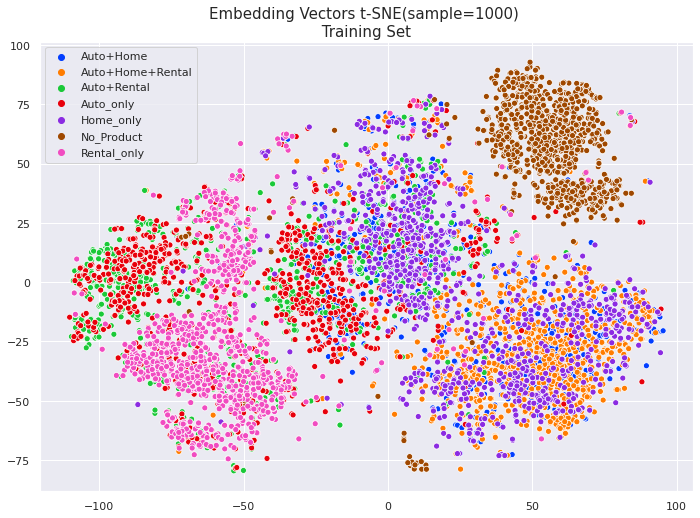

In [40]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(train_embedding[:,0], train_embedding[:,1], hue=prod_sample_train.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE(sample=1000) \n Training Set ",fontsize=15)

In [41]:
a,b=np.unique(prod_sample_val,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=1000) \n Validation Set ')

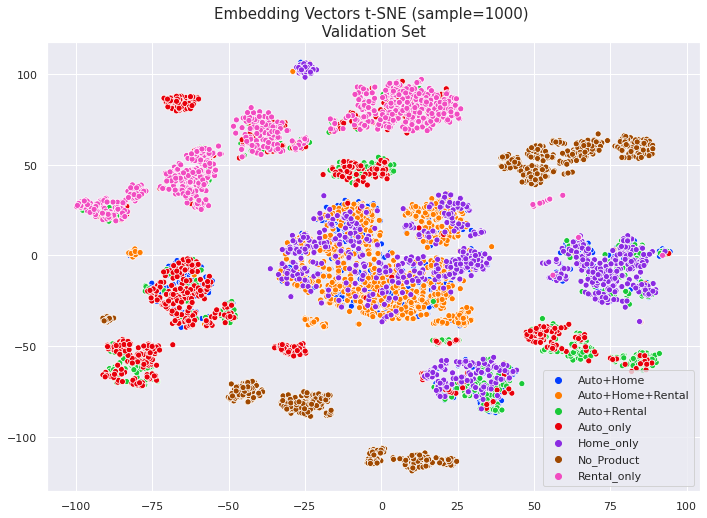

In [42]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(val_embedding[:,0], val_embedding[:,1], hue=prod_sample_val.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=1000) \n Validation Set ",fontsize=15)

In [43]:
a,b=np.unique(prod_sample_test,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=1000) \n Test Set ')

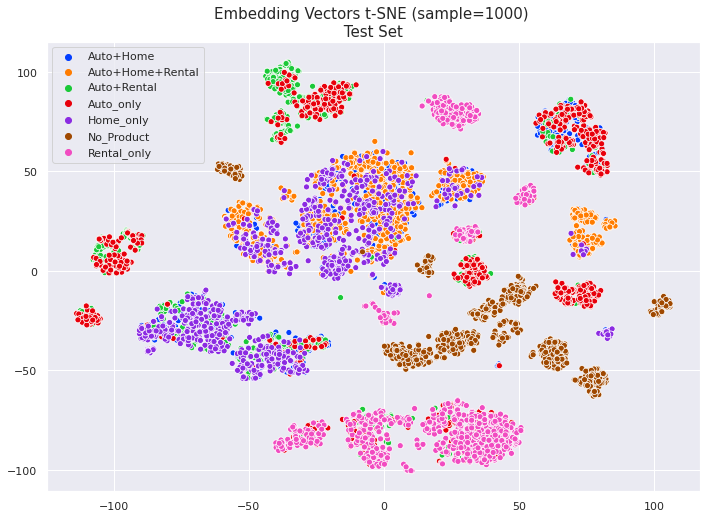

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(test_embedding[:,0], test_embedding[:,1], hue=prod_sample_test.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=1000) \n Test Set ",fontsize=15)